# Random Forest Model

Our team is taking a divide and conquer approach for modeling our data.  In this notebook, we'll be tuning a Random Forest model and then reviewing how well it performs. 

#### 1. [Installation and Importing of Libraries](#import)
#### 2. [Retreival of Data and Cleanup](#retrieval)
#### 3. [Resampling with SMOTE](#resampling)
#### 4. [Feature Reduction with Boruta](#reduction)
#### 5. [Random Forest GridSearch](#model)
#### 6. [Recursive Feature Elimintation](#RFE)
#### 7. [Performance Evaluation](#evaluation)
#### 8. [Visualization](#visualization)

### <a name="import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries. The first cell installs packages necessary for Boruta.

In [1]:
!pip install scikit-learn
!pip install optuna
!pip install graphviz

In [2]:
!pip install -q dtreeviz

In [22]:
##import libraries required for analysis
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, ConfusionMatrixDisplay
from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.metrics import precision_score, recall_score

import pickle
from imblearn.over_sampling import SMOTE
from sklearn.tree import plot_tree

### <a name="retrieval"></a>Retrieval of Data
As part of the work from other other SpIns, we have fully cleaned and formatted data.  In addition to that, we also have x and y datasets for train, test, and validation.

As we continue to hone the model, we're going through a few additional prepartory steps.  In order to facilitate testing different methods, some code will be commented out. 

Retrieval of Data -> Scaling the SMOTE resampled data -> Feature Reduction with Boruta -> GridSearch -> Recursive Feature Elimintation -> Model Validation

In [4]:
file_path = "/dsa/groups/casestudy2023su/team03/Data4/"

merged_df = pd.read_csv(file_path + "mros_merged.csv")

X_train = pd.read_csv(file_path + "X_train.csv")
X_test = pd.read_csv(file_path + "X_test.csv")
X_val = pd.read_csv(file_path + "X_validation.csv")

y_train = pd.read_csv(file_path + "y_train.csv")
y_test = pd.read_csv(file_path + "y_test.csv")
y_val = pd.read_csv(file_path + "y_validation.csv")

print("merged_df shape: ", merged_df.shape)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("X_validation shape: ", X_val.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)
print("y_validation shape: ", y_val.shape)


merged_df shape:  (5994, 381)
X_train shape:  (7528, 292)
X_test shape:  (599, 292)
X_validation shape:  (600, 292)
y_train shape:  (7528, 1)
y_test shape:  (599, 1)
y_validation shape:  (600, 1)


### <a name="resampling"></a>Resampling with SMOTE
In our pipeline, we've cleaned and resampled our data with SMOTE (Synthetic Minority Over-sampling Technique).  SMOTE is a popular technique used to address class imbalance in machine learning datasets. It works by synthesizing new minority class instances based on the existing data, effectively increasing the representation of the minority class. Using SMOTE helps to mitigate the imbalance problem with our fracture population, allowing the Random Forest model to learn from a more balanced distribution of data and potentially improve its performance in predicting fractures.

In [5]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Scale the resampled data
# Most of the data is binary making this unecessary but following good practice we're making sure everything 
# Is set to the same scale
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

### <a name="reduction"></a>Feature Reduction with Boruta
Since we're starting with 292 features, we need to try to reduce this to to a lower number.  By using Boruta, I was able reduce  to 115 confirmed features, 117 rejected, and 3 that were still tentative after 100 iterations.  

After experimenting with Boruta, I wasn't finding a signficant benefit over Recursive Feature Elimination and so I'm no longer using it as part of my pipeline.  

In [6]:
# Perform Boruta analysis for feature selection
boruta_selector = BorutaPy(estimator=RandomForestClassifier(n_estimators=75, max_depth=6),
                           n_estimators='auto', verbose=2, random_state=42)

# Fit Boruta selector on the training data
boruta_selector.fit(X_train_scaled.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	292
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	292
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	292
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	292
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	292
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	292
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	292
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	110
Tentative: 	29
Rejected: 	153
Iteration: 	9 / 100
Confirmed: 	110
Tentative: 	29
Rejected: 	153
Iteration: 	10 / 100
Confirmed: 	110
Tentative: 	29
Rejected: 	153
Iteration: 	11 / 100
Confirmed: 	110
Tentative: 	29
Rejected: 	153
Iteration: 	12 / 100
Confirmed: 	111
Tentative: 	28
Rejected: 	153
Iteration: 	13 / 100
Confirmed: 	111
Tentative: 	28
Rejected: 	153
Iteration: 	14 / 100
Confirmed: 	111
Tentative: 	25
Rejected: 	156
Iteration: 	15 / 100
Confirmed: 	111
Tentative: 	25
Rejected: 	156
Iteration: 	16 / 100
Conf

BorutaPy(estimator=RandomForestClassifier(max_depth=6, n_estimators=260,
                                          random_state=RandomState(MT19937) at 0x7F4ABCE11CA8),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F4ABCE11CA8, verbose=2)

In [13]:
# Select the relevant features using the Boruta mask
X_train_selected = X_train_scaled.loc[:, boruta_selector.support_]
X_test_selected = X_test_scaled.loc[:, boruta_selector.support_]
X_val_selected = X_val_scaled.loc[:, boruta_selector.support_]

### <a name="model"></a>Random Forest GridSearch
Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. Each tree is trained on a random subset of features and a random subset of the training data, and the final prediction is determined by aggregating the predictions of all individual trees, either by voting or averaging. This approach improves the model's robustness, reduces overfitting, and provides high accuracy in both classification and regression tasks.

We're also using GirdSearch to help identify the optimal hyperparameters of the Random Forest model hopefully resulting in better accuracy, reduced overfitting, and improved generalization on unseen data.

The **Best Parameters** result of the gridsearch were: 
 - **bootstrap: False** - Setting to False will trian each tree on the full dataset
 - **class_weight: {0: 1, 1: 4}** - Used to manage the imablanced dataset (ours is between 20% and 30%)
 - **max_depth: 15** - The maximum number of levels in each decision tree of the random forest
 - **min_samples_leaf: 30** - Larger values can help prevent overfitting by enforcing more samples per leaf node.
 - **min_samples_split: 5** - minimum number of samples required to split an internal node in a decision tree
 - **n_estimators: 100** - Number of decision trees to be built in the random forest
 
However, after additional manual tuning, I've decided to proceed forward with teh below due to Higher Precision and Recall of my minority class.  
 - **bootstrap: True** - Default
 - **class_weight: {0: 1, 1: 4}** - Used to manage the imablanced dataset (ours is between 20% and 30%)
 - **max_depth: 10** - The maximum number of levels in each decision tree of the random forest
 - **min_samples_leaf: 1** - Default
 - **min_samples_split: 4** - minimum number of samples required to split an internal node in a decision tree
 - **n_estimators: 75** - Number of decision trees to be built in the random forest

In [14]:
# In order to run this notebook without having to wait 1+ hour for the gridsearch, the results are input below

# # Create a RandomForestClassifier object
# rf_model = RandomForestClassifier(random_state=42)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 75, 100],
#     'max_depth': [15, 20, 25],
#     'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 4}], # Changing since None and 'balanced' never woreked
#     'min_samples_split': [5, 10, 15],  # Min Number of smaples to split an internal node when constructing each tree. Risk of overfit when too low.
#     'min_samples_leaf': [10, 20, 30],  
#     'max_leaf_nodes': [100, 200, 300],
#     'bootstrap': [False,True]
# }

# # Perform grid search using GridSearchCV
# grid_search = GridSearchCV(rf_model, param_grid, scoring='recall', cv=5, verbose=2)
# grid_search.fit(X_train_selected, y_train.values.ravel())

# # Get the best parameter values
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

In [15]:
# model = RandomForestClassifier(n_estimators=100,
#                                max_depth=15,
#                                class_weight={0: 1, 1: 4},
#                                min_samples_split=5,
#                                min_samples_leaf=30,
#                                max_leaf_nodes=100,
#                                bootstrap=True
#                               )

# I found that these parameters were giving me better 
model = RandomForestClassifier(n_estimators=75,
                               max_depth=10,
                               class_weight={0: 1, 1: 4},
                               min_samples_split=4) #,
                               #min_samples_leaf=30,
                               #max_leaf_nodes=100,
                               #bootstrap=True
                              #)


model.fit(X_train_selected, y_train.values.ravel())

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=10,
                       min_samples_split=4, n_estimators=75)

### <a name="evaluation"></a>Evaluation of the Model
With our Validation dataset, the ROC Curve is .50 model does not have a better than random chance of evaluation fracture.  We're going to need to go back to the drawing board... 

In [17]:
def makeConfusionMatrixandScore(model,y_actual,X_set,thresh=0.5):
    ###A function for printing out a confusion matric and classification report
    ###to consistantly evaluate model performance
    y_pred_prob = model.predict(X_set)
    y_pred = pd.Series(y_pred_prob).apply(lambda x: 1 if x > thresh else 0)
    
    cm = confusion_matrix(y_actual,np.round(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()    
    
    print(classification_report(y_actual, y_pred))
    
def plot_roc_and_prc(y_test, y_pred_proc):
    fpr,tpr,_ = roc_curve(y_test, y_pred_proc)
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc)
    
    
    auc = roc_auc_score(y_test, y_pred_proc)
    
    ap = average_precision_score(y_test, y_pred_proc)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    
    
    ##plot ROC
    ax1.plot(fpr,tpr)
    ax1.plot([0,1],[0,1], "k-", color = "r",lw=1)
    ax1.annotate(f"AUC: {auc:.2f}",(.75,.25),weight="bold",size=14)
    ax1.set_ylabel('True Positive Rate/ Recall')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_title("ROC Curve")
    
    ##plot Precision-Recall Curve
    ax2.plot(recall,precision)
    ax2.set_ylabel("Precision")
    ax2.set_xlabel("Recall")
    ax2.set_title("Precision-Recall Curve")
    ax2.annotate(f"AP: {ap:.2f}",(.5,.75),weight="bold",size=14)
    
    plt.show()

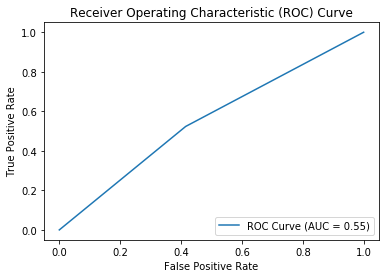

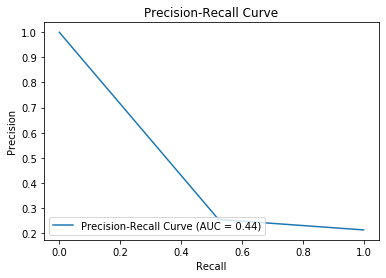

In [18]:
# Prepare the validation and test data for prediction
y_pred = model.predict(X_val_selected)

# Generate and plot the ROC curve
fpr, tpr, _ = roc_curve(y_val.values.ravel(), y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate and plot the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val.values.ravel(), y_pred)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, label='Precision-Recall Curve (AUC = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

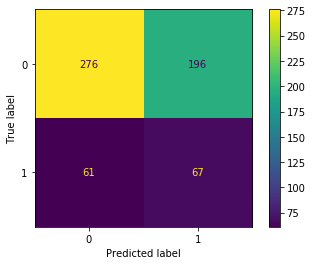

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       472
           1       0.25      0.52      0.34       128

    accuracy                           0.57       600
   macro avg       0.54      0.55      0.51       600
weighted avg       0.70      0.57      0.61       600



In [20]:
makeConfusionMatrixandScore(model,y_val.values.ravel(),X_val_selected)

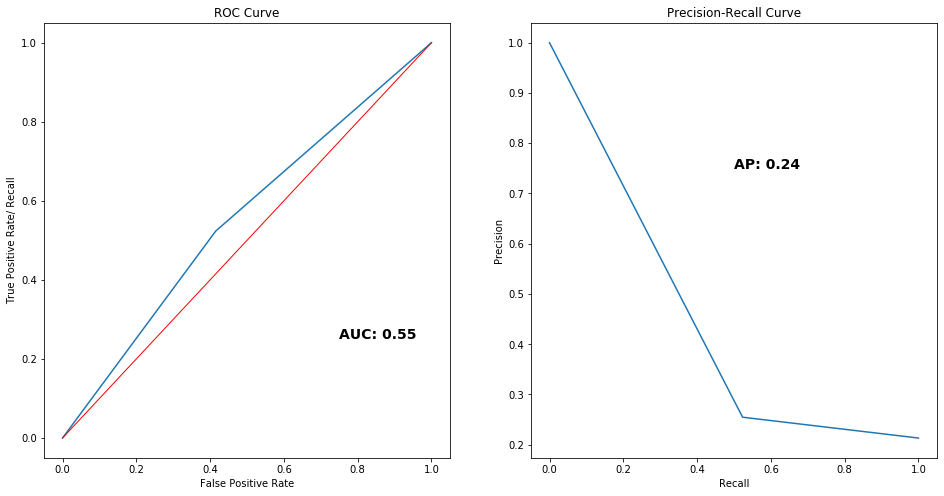

In [23]:
plot_roc_and_prc(y_val.values.ravel(),model.predict(X_val_selected))

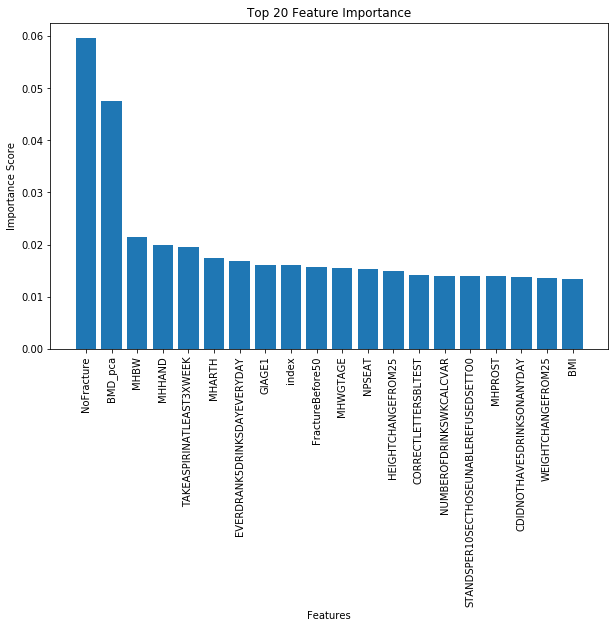

In [25]:
# Get feature importance
feature_importance = model.feature_importances_
sorted_indices = feature_importance.argsort()[::-1]  # Sort indices in descending order

# Select top 20 features
top_features = sorted_indices[:20]

# Plot feature importance for top 20 features
plt.figure(figsize=(10, 6))
plt.bar(range(20), feature_importance[top_features])
plt.xticks(range(20), X_train_selected.columns[top_features], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Top 20 Feature Importance')
plt.show()


### <a name="visualization"></a>Visual Exploration
The benefit of using an ensemble model is that we can trace how the tree is being generated.  The below is a starting point for waht we can potentially use for our tree visualization.  Likewise, it can help with explaining what factors contribute to the fracture population.  However, this will take much more cleaning up before it's presentable! 

In [26]:
tree = model.estimators_[0]  # Get the first tree from your random forest model
num_features = tree.tree_.n_features
print("Number of features:", num_features)

Number of features: 115


<IPython.core.display.Javascript object>


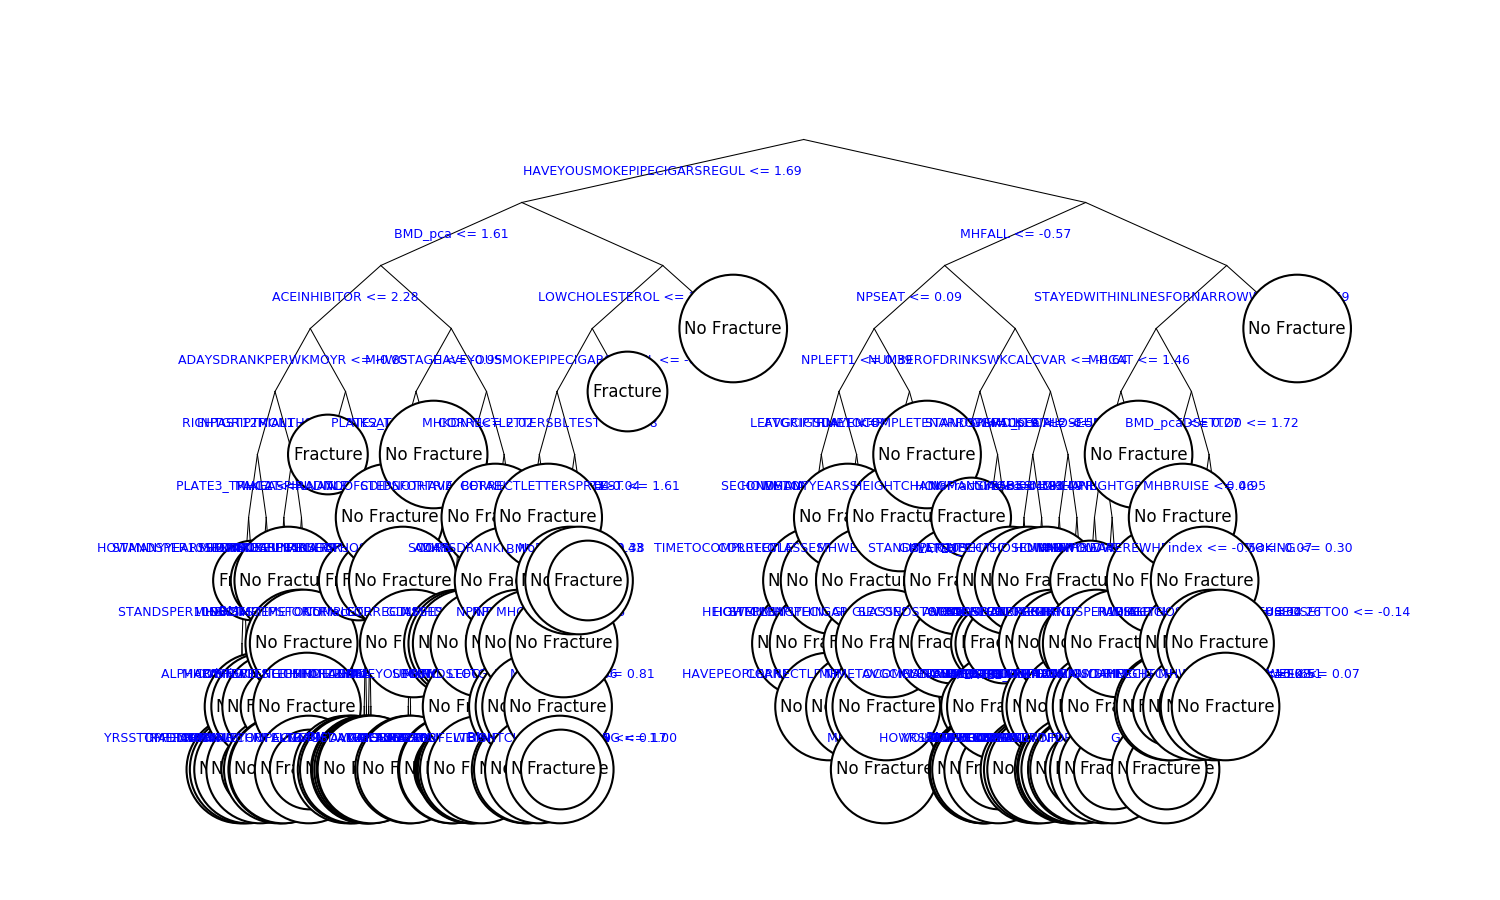

In [28]:
# Prepare the data
X = X_train_selected
y = y_train.values.ravel()

def plot_decision_tree(tree, feature_names, class_names, max_depth=None, max_features=None, total_features=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    # Get the tree parameters
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value.squeeze()

    # Define the position and width of each node
    depth = np.zeros(shape=n_nodes, dtype=np.int64)
    x = np.zeros(shape=n_nodes)
    y = np.zeros(shape=n_nodes)
    width = np.zeros(shape=n_nodes)
    depth[0] = 0
    x[0] = 0.5
    y[0] = 1.0
    width[0] = 1.0

    # Traverse the tree to assign positions to each node
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:
            depth[children_left[i]] = depth[i] + 1
            depth[children_right[i]] = depth[i] + 1
            x[children_left[i]] = x[i] - width[i] / 4
            x[children_right[i]] = x[i] + width[i] / 4
            y[children_left[i]] = y[i] - 0.1
            y[children_right[i]] = y[i] - 0.1
            width[children_left[i]] = width[i] / 2
            width[children_right[i]] = width[i] / 2

    # Plot the tree nodes and edges
    lines = []
    for i in range(n_nodes):
        if feature[i] != -2 and (max_depth is None or depth[i] <= max_depth):
            lines.append(ax.plot([x[i], x[children_left[i]]], [y[i], y[children_left[i]]], 'k-', linewidth=0.5)[0])
            lines.append(ax.plot([x[i], x[children_right[i]]], [y[i], y[children_right[i]]], 'k-', linewidth=0.5)[0])
            ax.text((x[i] + x[children_left[i]]) / 2, (y[i] + y[children_left[i]]) / 2, f'{feature_names[feature[i]]} <= {threshold[i]:.2f}', ha='center', va='center', fontsize=6, color='blue')
        elif max_depth is None or depth[i] <= max_depth:
            label = np.argmax(values[i])
            ax.text(x[i], y[i], class_names[label], ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

    if max_features is not None and total_features is not None:
        feature_text = f"Max Features: {max_features}\nTotal Features: {total_features}"
        ax.text(0.5, -0.1, feature_text, ha='center', va='center', fontsize=8, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    def on_xlims_change(axes):
        ax.lines = lines
        ax.set_xlim(*axes.get_xlim())
        ax.set_ylim(*axes.get_ylim())
        ax.figure.canvas.draw()

    fig.canvas.mpl_connect('xlim_changed', on_xlims_change)
    fig.canvas.mpl_connect('ylim_changed', on_xlims_change)

    plt.show()

# Need to Enable interactive notebook mode
%matplotlib notebook

# Use the first tree from my model and render
tree = model.estimators_[0]  
feature_names = X.columns  
class_names = ['No Fracture', 'Fracture']

plot_decision_tree(tree, feature_names, class_names, max_depth=None)

### <a name="rfe"></a>Recursive Feature Elimination
With limited performance improvement from Boruta, we wanted to also test using Recursive Feature Elimintation (RFE).  Similaring to the tuning that we're able to use with GridSearch, the below looop allows us to test several different number of features.  

In [29]:
# Define the range of n_features_to_select values to test
#n_features_to_select_values = [20, 30, 40, 50]
n_features_to_select_values = [5]

# Iterate over the n_features_to_select values
for n_features_to_select in n_features_to_select_values:
    # Create RFE object with the current n_features_to_select value
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    X_selected = rfe.fit_transform(X, y)
    selected_feature_names = X.columns[rfe.support_]

    # Filter the DataFrame to include only selected features
    X_train_selected = X[selected_feature_names]
    model.fit(X_train_selected, y_train.values.ravel())

    # Predict on the validation set (neccesary to create a temp compy of X_val_selected otherwise it's overwritten each loop)
    X_val_selected_temp = X_val_selected.copy()
    X_val_selected_temp = X_val_selected_temp[selected_feature_names]
    val_predictions = model.predict(X_val_selected_temp)

    # Calculate AUC performance 
    val_auc_score = roc_auc_score(y_val, val_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)
    val_f1_score = f1_score(y_val, val_predictions)
    # Having issues with everything being predicted as fracture so setting zero_division to 1 for warning
    val_precision = precision_score(y_val, val_predictions, zero_division=1)
    val_recall = recall_score(y_val, val_predictions, zero_division=1)
    class_report = classification_report(y_val, val_predictions, zero_division=1)

    # Print validation metrics for the current n_features_to_select value
    print(f"n_features_to_select = {n_features_to_select}")
    print("Validation AUC:", val_auc_score)
    print("Validation Accuracy:", val_accuracy)
    print("Validation F1-score:", val_f1_score)
    print("Validation Precision:", val_precision)
    print("Validation Recall:", val_recall)
    print("Classification Report:")
    print(class_report)
    print()

n_features_to_select = 5
Validation AUC: 0.5607123940677966
Validation Accuracy: 0.45666666666666667
Validation F1-score: 0.3682170542635659
Validation Precision: 0.24484536082474226
Validation Recall: 0.7421875
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.38      0.52       472
           1       0.24      0.74      0.37       128

    accuracy                           0.46       600
   macro avg       0.54      0.56      0.45       600
weighted avg       0.72      0.46      0.49       600




<IPython.core.display.Javascript object>


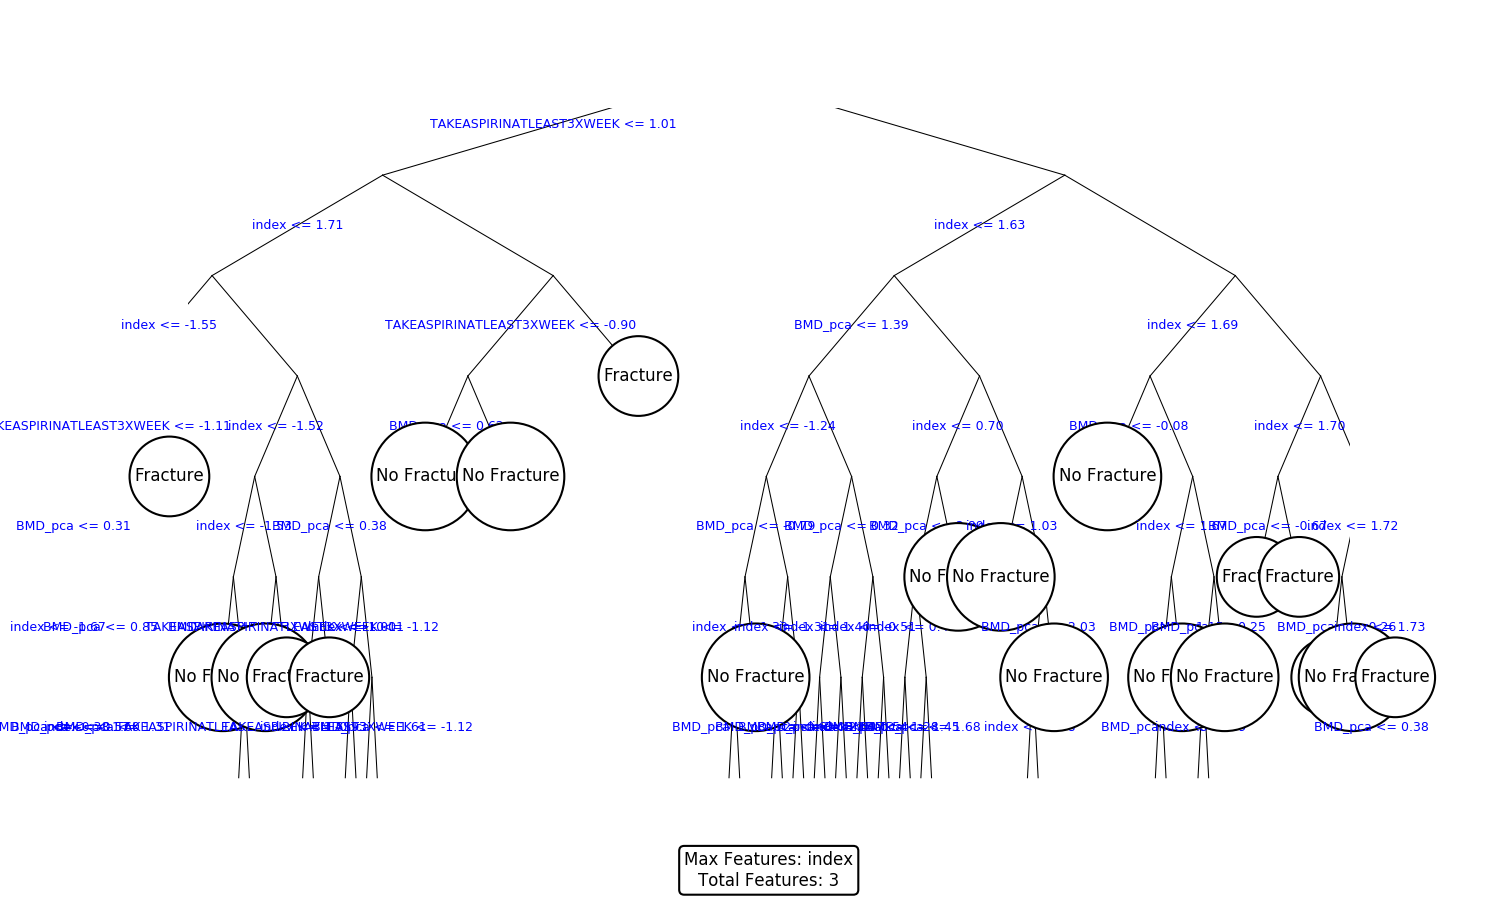

In [78]:
# Find the RFE with the highest performance
max_auc_index = np.argmax(val_auc_score)
max_auc_features = selected_feature_names[max_auc_index]
#print(selected_feature_names)

# Visualize the decision tree with the RFE that had the highest performance
tree_max_auc = model.estimators_[max_auc_index]
plot_decision_tree(tree_max_auc, feature_names=selected_feature_names, class_names=['No Fracture', 'Fracture'], max_depth=6, max_features=max_auc_features, total_features=len(X_train_selected.columns))

In [79]:
# Pickle the RandomForest model for later use
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)